Introduction
-------------------------------------

In this project, we are detecting vehicles in an image using traditional computer vision features such as spatial binning, color histogram and histograms of oriented gradients (HOG). Before we begin, lets explore the training data set

In [1]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

def plot_training_image(img_name):
        image = mpimg.imread(car)
        plt.figure()


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
from sklearn.utils import shuffle

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Divide up into cars and notcars
images = glob.glob('*/**/*/*.png')
cars = []
notcars = []
for image in images:
    if 'non-vehicle' in image:
        notcars.append(image)
    else:
        cars.append(image)
cars = shuffle(cars)
notcars = shuffle(notcars)
data_look(cars, notcars)

{'data_type': dtype('float32'),
 'image_shape': (64, 64, 3),
 'n_cars': 8792,
 'n_notcars': 8968}

Lets take a look at some of the training data:

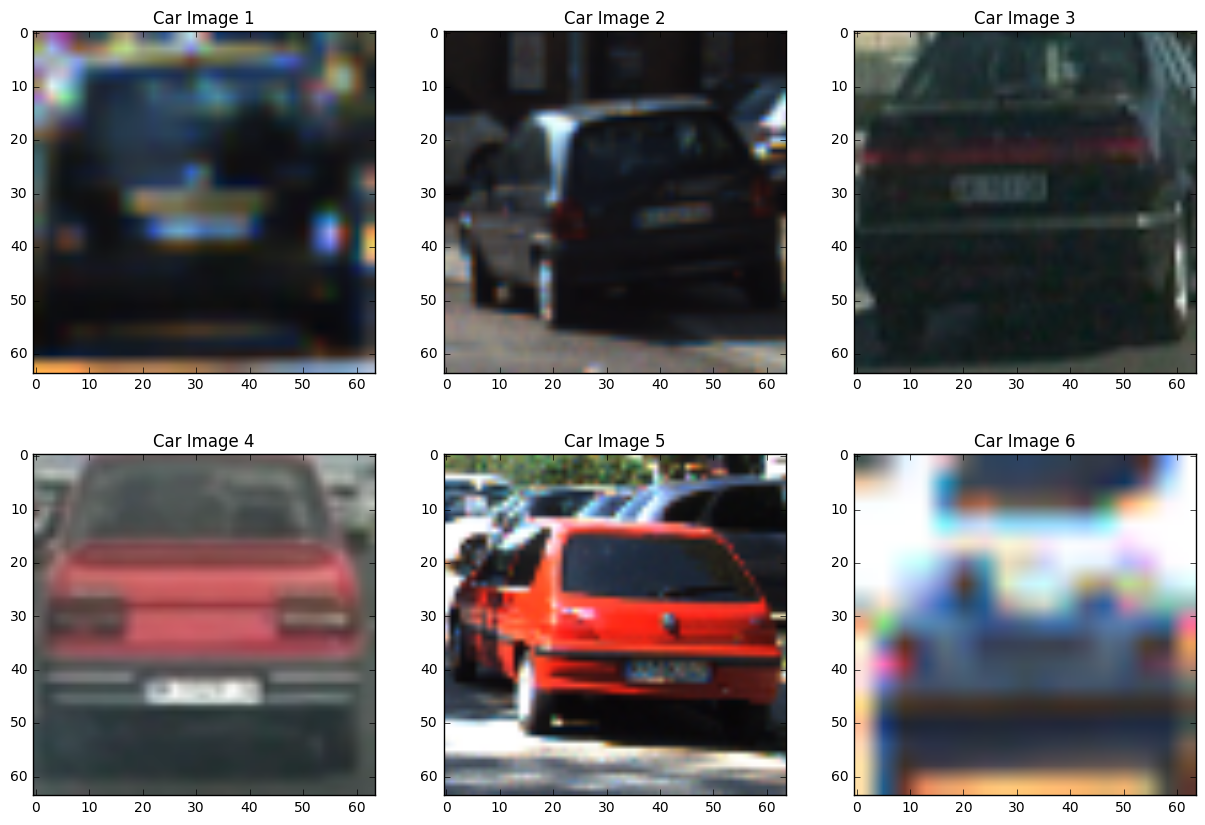

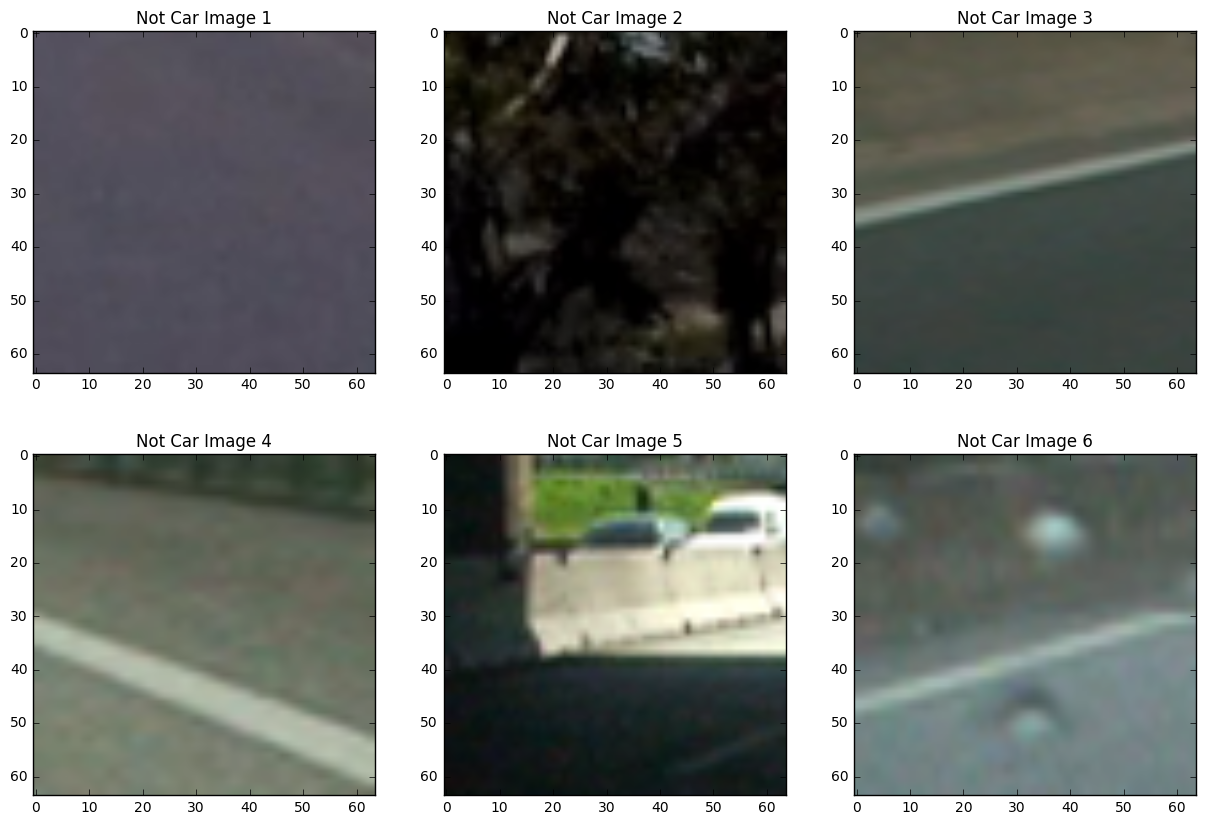

In [2]:
import random
def subplot_array(subplot_width,subplot_height, dataset, rand = True,title_str = 'Image: '):
    plt.figure(figsize=(subplot_width*5,subplot_height*5))
    for idx in range(subplot_width*subplot_height):
        plt.subplot(subplot_height, subplot_width,idx+1)
        if rand:
            index = random.randint(0, len(dataset))
        else:
            index =idx
        image = mpimg.imread(dataset[index])
        plt.imshow(image)
        title_str_i = title_str + str(idx+1)
        plt.title(title_str_i)
        
%matplotlib inline
subplot_width = 3
subplot_height = 2


subplot_array(subplot_width, subplot_height, cars, title_str = 'Car Image ')
plt.show(block = False)

subplot_array(subplot_width, subplot_height, notcars, title_str = 'Not Car Image ')
plt.show(block = False)
    


When we are actually testing our classifier, we will be using images from a camera mounted on top of the car. A selected subsample of these images was provided for testing. These can be seen here:

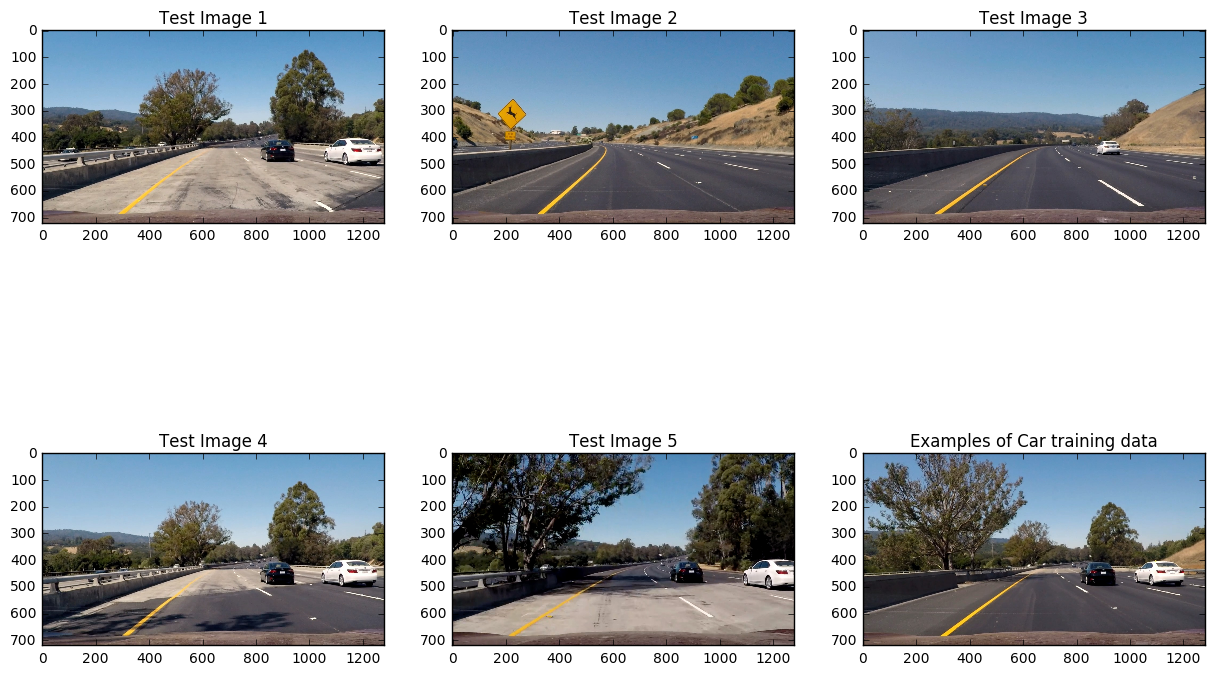

In [3]:
test_images = ['test_images/test1.jpg',
               'test_images/test2.jpg',
               'test_images/test3.jpg',
               'test_images/test4.jpg',
               'test_images/test5.jpg',
               'test_images/test6.jpg']

%matplotlib inline
subplot_width = 3
subplot_height = 2

subplot_array(subplot_width, subplot_height, test_images,rand = False, title_str = 'Test Image ')
plt.title('Examples of Car training data')
plt.show(block = False)

Histogram of Oriented Gradients (HOG)
-------------------------------------

**Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.**

I extracted the HOG features using a function called "get_hog_features" on lines 7 to 24 of helper_functions.py. This function calls the skimage method called "hog" to extract the hog features given specific parameters such as the number of orientations, pixels per cell, and cells_per_block. After some trial and error, I ended up choosing the following parameters:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb  
orient = 9  # HOG orientations  
pix_per_cell = 8 # HOG pixels per cell  
cell_per_block = 2 # HOG cells per block  
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"  

One parameter that made a significant difference when tweaking was the color space. the HSV and YCrCb colorspaces seemed to work the best with YCrCb providing slightly better results. While I was able to get fairly good results with only a single HOG channel, using all three channels also seemed to produce the best results

The pixels per cell feature was also important. I ended up chosing 8 pixels per cell becausesome of the important features such as tailights and maybe mirrors were around this size. The number of orientations I chose was 9 orientations. While I was able to get fairly comparable results with fewer orientations, I chose 9 becuase I could get slightly better results with this value. The rate of return decrease after this value.

The cell_per_block paramater instructs the skimage hog method to perform block normalization. This gives the hog features some robustness to variations in intesity caused by shadows or other. A cell_per block of 2 was chosen after trying a few different values.

During training, I calculated these hog features on each of the images used for training. This can be seen on lines 43-54 of train_classifier.py, which calls the "extract_features" function. The actual line that calls the "get_hot_features" funciton mentioned above is in the "extract_features()" function on lines 90-11 of helper_functions.py

During testing on the video images, instead of computing the HOG features on each individual subimage, I calculated HOG features on a scaled version  of the entire image, and the subsampled from these features when using the sliding window approach. This can been seen on lines 344-356 of the find_cars function in helper_functions.py. This is a more efficient approach.

The images below show two car and two notcar examples of what the original image, and the hog features for each channel look like. It is pretty clear from these that the outline of a car can be easily distinguished from other random features.

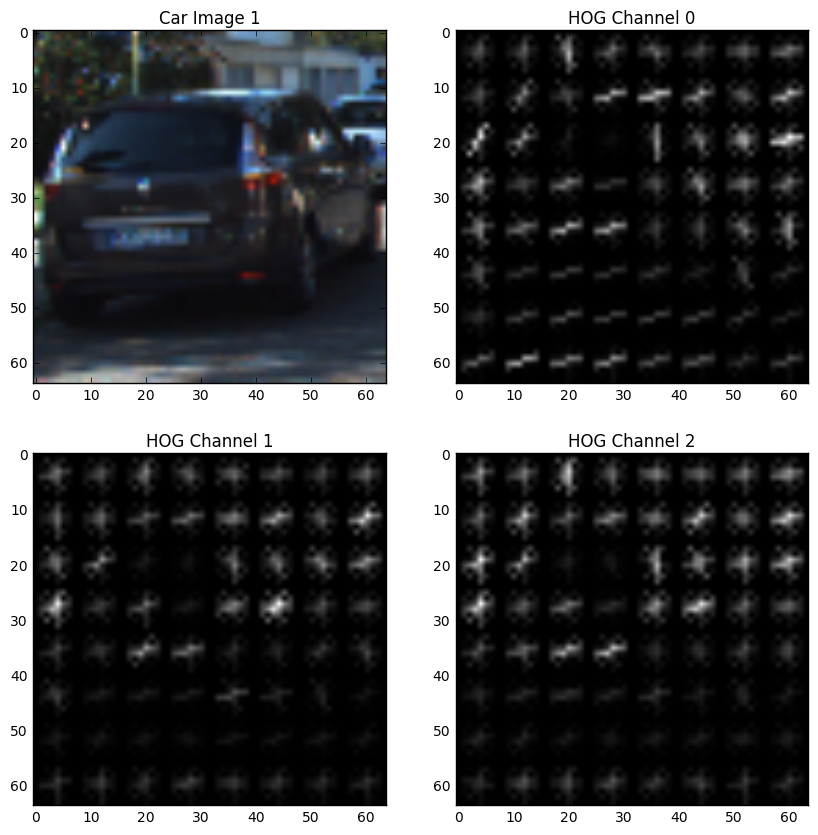

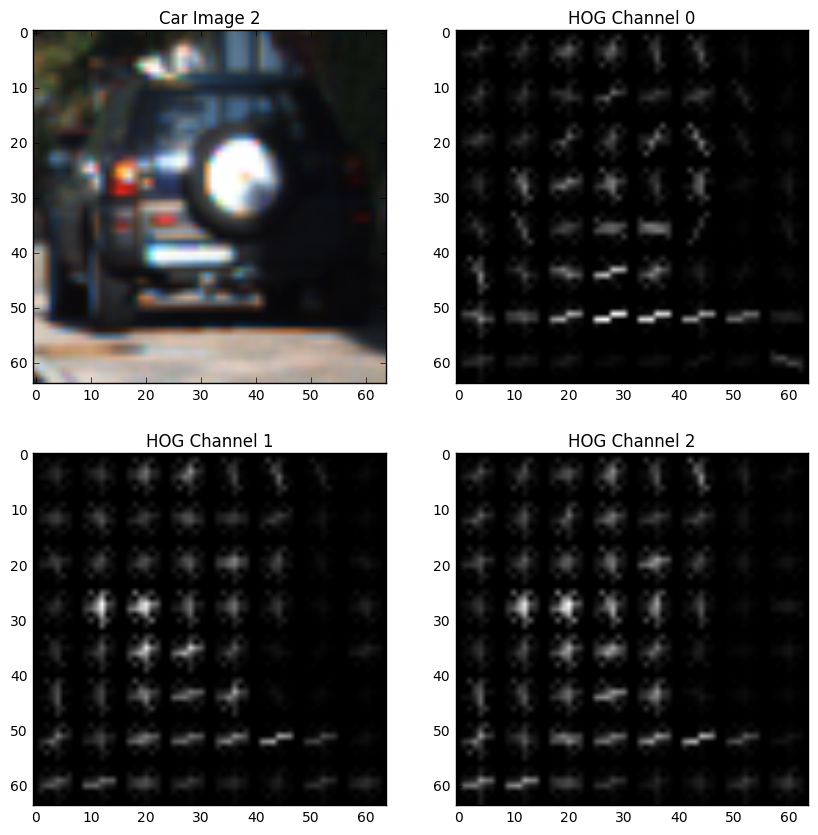

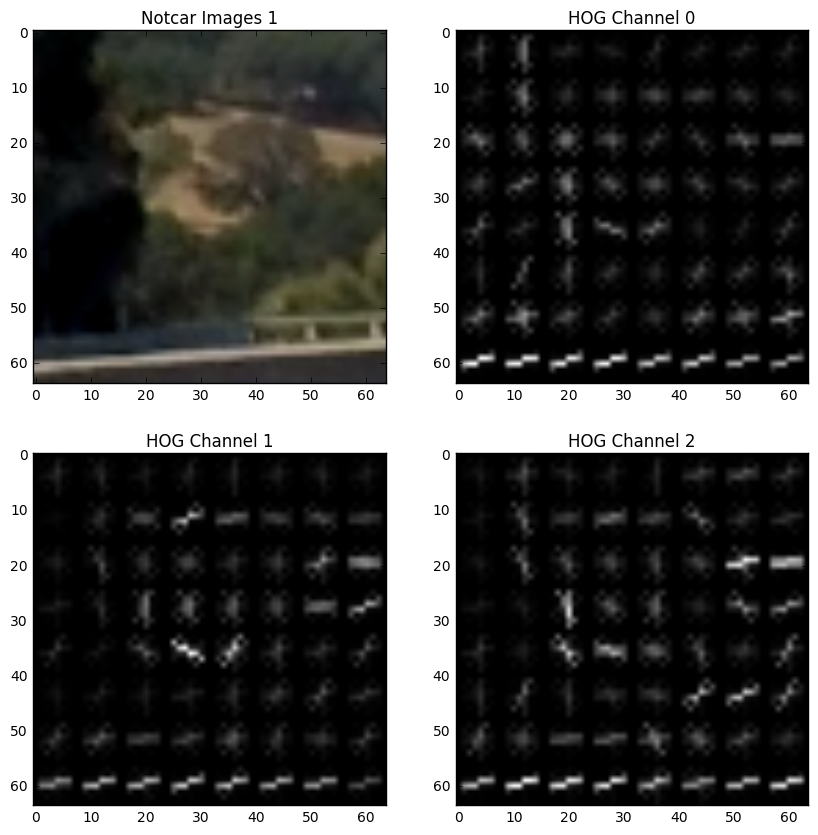

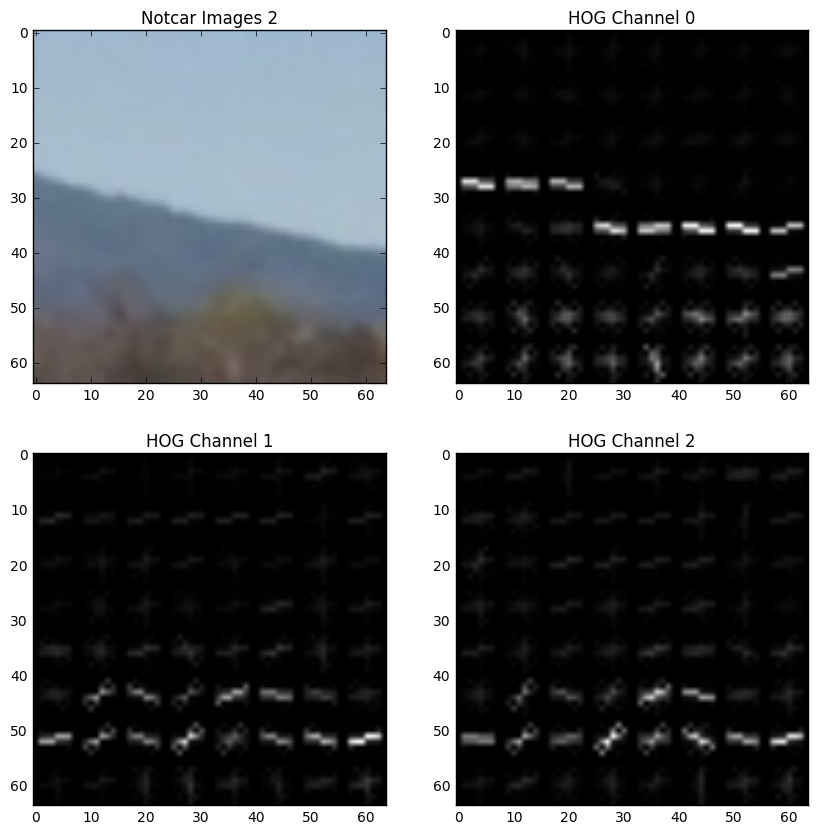

In [4]:
exec(open('helper_functions.py').read())
%matplotlib inline
# Call our function with vis=True to see an image output
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb  
orient = 9  # HOG orientations  
pix_per_cell = 8 # HOG pixels per cell  
cell_per_block = 2 # HOG cells per block  
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

def plot_hogs(image_names, title_str):
    for idx in range(len(image_names)):
        image = mpimg.imread(image_names[idx])
        plt.figure(figsize = (10,10))
        plt.subplot(2,2,1)
        plt.imshow(image)
        plt.title(title_str +str(idx+1))
        image = convert_color(image, color_space = color_space)
        for channel in range(image.shape[2]):
            features, hog_image = get_hog_features(image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
            plt.subplot(2,2,channel+2)
            plt.imshow(hog_image, cmap='gray')
            plt.title('HOG Channel ' + str(channel))
        plt.show(block = False)

plot_hogs(cars[1:3],'Car Image ')
plot_hogs(notcars[1:3], 'Notcar Images ')

    

**Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).**

In addition to the HOG features, I also used binned spatial features from each channel and color histogram features for training my classifier. These were all in the 'YCrCb' colorspace just like the HOG channels. The code for computing the binned spatial features is found in helper_functions.py in the function "bin_spatial" on lines 49-53. The code for computing the color histogram features can be found on in helper_functions.py in the function called "color_hist" on lines 57-65.

All of HOG, spatial, and histogram features were all concatenated into a single feature vector to be used as an input to the classifier feature. The total length of my feature vector was 8460. This is on line 46 of train_classifier.py

Before training the classifier, these features are all normalized to zero mean and unit variance using the sklearn StandardScaler function to ensure that badly scaled features do not dominate the svn training. This is found on lines 48-60 of train_classifier.py

In order to test the accuracy of my classifier, I split my data into training and test data. I reserved 20% for testing. I also randomized the training data to make sure the timeseries nature of the data did not affect the classifier. This can be found on lines 67-72 of train_classifier.py

I chose to use a support vector machine (SVM) to train my classifier. Specifically, I used the LinearSVC function from the sklearn toolkit. This classifier produced pretty good results, but with a more time I would have played around with trying to use different classifiers such as a decision tree or maybe a neural network using these features as inputs. The SVN training can be found on lines 77-81 of train_classifier.py

After training, I checked the results of my classifier agains the test data and achieved an accuracy of 98.85%.

I have plotted examples of the spatial and histogram features for a car image below.



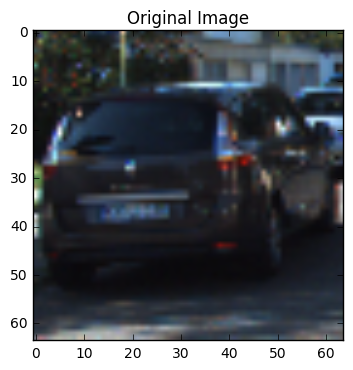

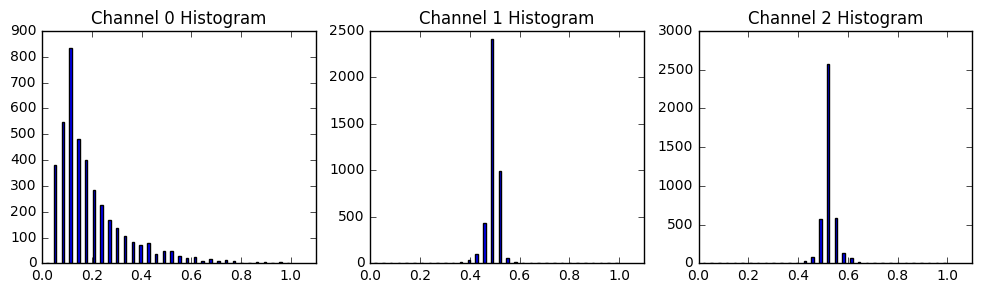

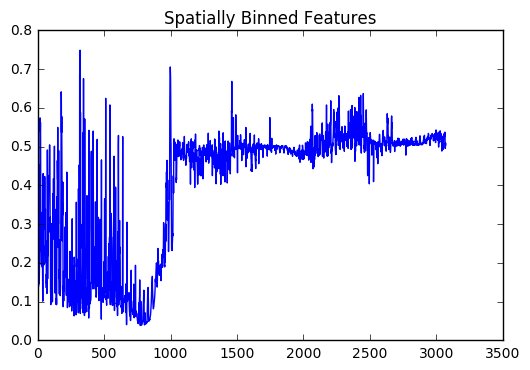

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

image = mpimg.imread(cars[1])
# plot original image
plt.imshow(image)
plt.title('Original Image')

# convert colorspace
image = convert_color(image, color_space = color_space)

#plot histogram features
bin_edges = np.linspace(0.,1.,hist_bins+1) 
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
features = color_hist(image, nbins=hist_bins, bins_range=(0., 1.))

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, features[0:32], width=0.01)
plt.xlim(0, 1.1)
plt.title('Channel 0 Histogram')
plt.subplot(132)
plt.bar(bin_centers, features[32:64], width=0.01)
plt.xlim(0, 1.1)
plt.title('Channel 1 Histogram')
plt.subplot(133)
plt.bar(bin_centers, features[64:96], width=0.01)
plt.xlim(0, 1.1)
plt.title('Channel 2 Histogram')
plt.show()


# feature_vec = bin_spatial(image, size=(32, 32))

# Plot spatial binned features
feature_vec = bin_spatial(image, size=(32, 32))
plt.figure()
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

Sliding Window Search
--------------------

**Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?**

I have two implementations of the sliding window search:  

The generates a number of windows with different parameters, then subsamples and scales the original image to compute the features using the original extract_features function used in training to determine if the window contains a car or not. The window generator is the "slide_window" function on lines 112-151 of helper_functions.py. The subsampler and feature extraction function is the "search_windows" function on lines 208 to 237 of helper_functions,py

These functions worked, but in order to be more efficient, it is only necesssary to compute the HOG features over the entire image once, and then to subsample these HOG features. This is exactly what the find_cars function does. By scaling the image up or down, the function is also able to subsample the image with different sized windows. This function is implemented in the "find_cars" function on lines 277 to 350 of helper_functions.py

In order to further make my sliding window search more efficient, I limited the sliding window search to the area in the image where cars can be expected (below the horizon, and to the right of the left lane ending). Furthermore, we know that small cars will appear higher up in the horizon, so the smaller the search window, the more I limited my range within the image that I searched. The scales were selected to encapsulate the different sized cars that I want to detect, and the overlap was chosen to be two cells in order to detect a car more than once in each image to increase the accuracy. The scales and window search areas used in the pipeline are on lines 48-50 of pipeline.py. These are looped over using the find 55-61 of pipeline.py in the detection_pipeline function.

One tricky part was to make sure that the overlapping windows went all the way to the right edge of the image to detect cars in this area. This was accomplished through trial and error in some cases, and also making the ranges multiples of 16 (2*pixels_per_cell).

An image showing all of the windows searched can be seen below:

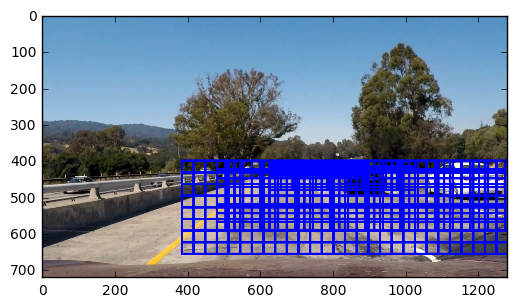

In [6]:
exec(open('pipeline.py').read())
image = mpimg.imread('test_images/test1.jpg')
init = True
draw_img, all_windows, hot_windows, heat = detection_pipeline(image, return_info = True, alpha = 0.8)

window_img = draw_boxes(image, all_windows, color=(0, 0, 255), thick=6)    
plt.figure( )
plt.imshow(window_img)
plt.show(block=False)



**Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?**

In order to detect the boundaries of where cars are in the image, I created something called a "heat map" This heat map is of the same size of the image where each pixel is initialized to 0. Once windows with cars are detected, a value of "1" is added for all of the pixels in each of the detected windows. This is accomplished using the "add heat" function on lines 240 to 253 of helper_functions.py. There is also a filter implementation here, which I will discuss later.

Bounding boxes are then detected and drawn using the scipy "label" function which draws bounding boxes around areas in the image with values greater than a threshold. The labelling code can be found on lines 74-75 of pipeline.py in the detection_pipeline function. The code that draws the bouding boxes on the image can be found in the draw_labeled_bboxes function on lines 261-274 of the helper_functions.py file.

As I already mentioned, there were many things that I did to improve the performance of my classifier in the training stage. This included parameter selection and chosing all of the features relevant to the detection. In the pipeline, the sliding window approach with many overlapping windows allowed me to detect the cars multiple times. This allowed me to increase the threshold used in determining the bounding boxes to filter out false positives. A value of 1.5 was used. 

Below are some examples of the results. The image on the right shows the heat map  with the more saturated pixels indicating areas where windows with cars detected overlap. The image on the left shows the bounding boxes derived from these detections. It is clear from these that the images close to the car are consistently detected, with few or no false positives.

Test Image  1  Results


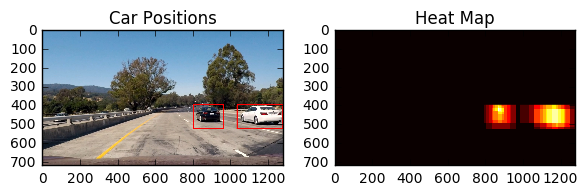

Test Image  2  Results


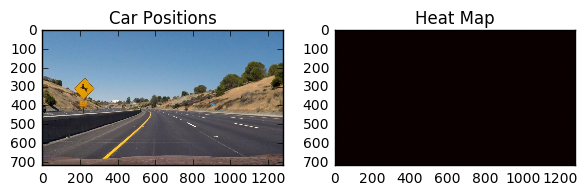

Test Image  3  Results


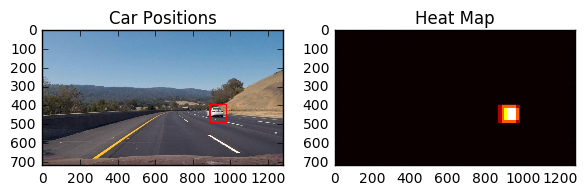

Test Image  4  Results


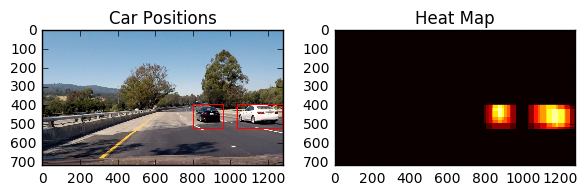

Test Image  5  Results


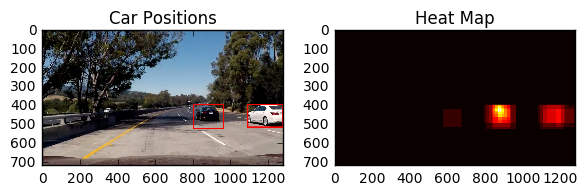

Test Image  6  Results


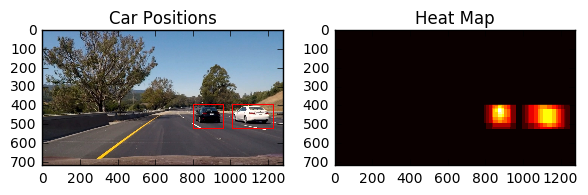

In [7]:
exec(open('pipeline.py').read())

for i in range(len(test_images)):
    image_name = test_images[i]
    image = mpimg.imread(image_name)
    init = True
    draw_img, all_windows, hot_windows, heat = detection_pipeline(image, return_info = True, alpha = 0.)
    print('Test Image ',i+1,' Results')
    plot_heat(draw_img,heat)

Video Implementation
------------------------

**Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)**

The video can be found in the link below. I also ran laneline detection from Project 4 for a more complete video.
https://youtu.be/LcCVvu6ea8w

**Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.**

In order to filter out false positives and generally make the vehicle detections smoother, I used a first order filter on the heatmap between frames. In other words, give the heat map from the previous frame (heat_map_prev) and the unfiltered heatmap from this frame, the heatmap used for vehicle detection is:

heatmap = alpha*heatmap_prev + (1-alpha)*heatmap_unfiltered

I used an alpha of 0.8 for some significant filtering. With this filtering, I have no false positives in the video

As mentioned previously, this is implemented in the add_heat function on lines 240 to 253 of the helper_functions.py file. There is also some initialization logic here.

Discussion
------------

**Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?**

One of the limitations of the algorithm is that it only detects vehicles relatively close to the car. By increasing the amount of sliding windows and decreasing their size, this could be improved.

In order to increase the vehcile tracking capability, it could also be useful to keep track of specific videos in the code and track their location. Potentially, you could even track their speed relative to the camera and propogate their position in subsequent frames.

Other challenges would also be camera occlusions including rain, snow, and or dirt, or simply a large amount of glare from the sun. These would have to be addressed by more thorough training of the classifier and possibly using data augmentation to simulate these conditions with the existing images.

With more time, I would like to try to use other classifiers with the same features such as a convolutional neural network. 